# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
import warnings
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

Using TensorFlow backend.


# One Loci No Correlation

In [2]:
def trait_simulation_oneloci_nocorr(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# Two Loci No Correlation

In [3]:
def trait_simulation_twoloci_nocorr(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    var_g = var_g/2
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    #two random numbers without replacement
    loci = random.sample(range(0,loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    print(SNP2[0:30])
    #doesnt matter which SNP we choose from since their both same length
    individuals = len(SNP1)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i_SNP1 = np.random.normal(0, sigma_b)
    b_i_SNP2 = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G1 and G2 will be the jth individual from our SNP1 and SNP 2 for the loci
        G1 = SNP1[k]
        G2 = SNP2[k]
        Y_j = (G1*b_i_SNP1)+(G2*b_i_SNP2) + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# Two Loci Correlation

In [4]:
def trait_simulation_twoloci_corr(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    var_g = var_g/2
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    #two random numbers without replacement
    loci = random.sample(range(0,loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    #doesnt matter which SNP we choose from since their both same length
    individuals = len(SNP1)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i_SNP1 = np.random.normal(0, sigma_b)
    b_i_SNP2 = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G1 and G2 will be the jth individual from our SNP1 and SNP 2 for the loci
        G1 = SNP1[k]
        G2 = SNP2[k]
        Y_j = G1*b_i_SNP1+G2*b_i_SNP2 + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

## G1 is for one loci no correlation

In [5]:
G1, samples_n,loci_m = trait_simulation_oneloci_nocorr(500,20,.7,.3)

## G2 is for two loci no correlation

In [6]:
G2, samples_n,loci_m = trait_simulation_twoloci_nocorr(100,10,.9,.2)

[ 1.83322428  0.37828438  0.37828438  0.37828438  0.37828438 -1.07665553
  1.83322428 -1.07665553 -1.07665553  1.83322428  0.37828438  0.37828438
  0.37828438  0.37828438 -1.07665553 -1.07665553  0.37828438 -1.07665553
  0.37828438  0.37828438 -1.07665553  0.37828438 -1.07665553 -1.07665553
  1.83322428  0.37828438 -1.07665553  0.37828438  0.37828438  1.83322428]


In [ ]:
# #individuals
# n = 500
# #loci
# m = 20


# #here every matrix entree has to be zero or one, with having a f_i probability to get selected
# #frequency of alleles, random uniform distribution between 0 and 1, with m samples
# f_M = np.random.uniform(0,1,m)

# #initialize G matrix
# # G = np.zeros((n, m));

# # #will be used to flip a coin based on f_i
# # #higher f_i frequency = higher chance of returning true
# # def loci_frequency_flip(f_i):
# #     return random.random() < f_i

# # #use this if I wanted to populate entire G matrix
# # #k are the colums(loci)
# # for k in range (0, len(G[0])):
# #     # j are the rows(individuals)
# #     for j in range (0, len(G)):
# #         #frequency of loci k we are currently on
# #         if(loci_frequency_flip(f_M[k])):
# #             G[j,k] = 1
# #creates a G matrix where each loci has a chance to be 0 or 1 based on their 
# #frequency from the uniform distribution f_m
# G = np.random.binomial(n=2,p = f_M, size =  (n,m))

# # If 0, independently standardize each feature, otherwise (if 1) standardize each sample, so choosing 0 
# # to do column wise scaling
# G = preprocessing.scale(G, axis=0)
# # choose random SNP
# loci =random.randint(0,m-1)

# #select SNP
# SNP = G[:,loci]

# #preview of the data
# print(SNP[0:30])

# F_i distribution plot

In [ ]:
# #use this to see distribution of f_i frequency
# bin_size = 20
# count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

# plt.xlabel('X [0,1]')
# plt.ylabel('Count')
# plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
# plt.axis([0, 1, 0, len(f_M]) # x_start, x_end, y_start, y_end
# plt.grid(True)

# plt.show(block = False)

# Split the data

In [7]:
#split data into test and train
X = G2[:,0:len(G2[0])-2]

#last column is the appended Y vector we predicted
y = G2[:,len(G2[0])-1]

#split the data, 70% training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [ ]:
#training the algorithm
linReg = LinearRegression() 
linReg.fit(x_train, y_train) 

In [ ]:
#test the model on test data
y_predict = linReg.predict(x_test)

# Linear Regression Evaluation

In [ ]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

# Prediction Error

In [ ]:
#prediction error plot
diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

# Extract SHAP values

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(linReg.predict, x_train)
shap_values = explainer.shap_values(x_train)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values,x_train)

# Random Forest Regressor

In [ ]:
#Random Forest Regression
#initialize tree with a node depth of 10 and 50 decision trees
forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
forReg.fit(x_train, y_train)

# RFR Evaluation

In [ ]:
y_predict2 = forReg.predict(x_test)
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict2), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict2), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict2)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict2), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict2), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict2), 2))

# RFR Prediction Error

In [ ]:
diff = y_test - y_predict2
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

# RFR SHAP Values and Plots

In [ ]:
warnings.filterwarnings("ignore")
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values,x_train)

# SHAP Interaction Value

In [ ]:
shap.initjs()
shap_interaction_values = shap.TreeExplainer(forReg).shap_interaction_values(x_train)

In [ ]:
shap.summary_plot(shap_interaction_values, features=x_train, max_display=4)

# Starting Neural Networks

In [ ]:

half =  round((loci_m-1)/2)
model = Sequential()
model.add(Dense(32, activation='relu', input_dim = loci_m-1))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu', input_dim = 32))
model.add(Dropout(0.25))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
model.summary()

In [ ]:
y_predict = model.predict(x_test)

In [ ]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

In [ ]:
y_predict = model.predict(x_test)
y_predict = y_predict.reshape(len(y_predict))

diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
shap_values = explainer.shap_values(x_train)
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

# Neural Network Compressed

In [ ]:

half =  round((loci_m-1)/2)
model = Sequential()
model.add(Dense(half, activation='relu', input_dim = loci_m-1))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu', input_dim = half))
model.add(Dropout(0.25))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
model.summary()

In [ ]:
y_predict = model.predict(x_test)

In [ ]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

In [ ]:
y_predict = model.predict(x_test)
y_predict = y_predict.reshape(len(y_predict))

diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
shap_values = explainer.shap_values(x_train)
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [8]:
#need to inout training data, and number of features(loci) you are using
def NN_Expanded_SHAP(x_train,y_train,loci_m):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim = loci_m-1))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = 32))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
    shap_values = explainer.shap_values(x_train)
    return shap_values

In [ ]:
def NN_Compressed_SHAP(x_train,y_train,loci_m):
    half =  round((loci_m-1)/2)
    model = Sequential()
    model.add(Dense(half, activation='relu', input_dim = loci_m-1))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = half))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
    shap_values = explainer.shap_values(x_train)
    return shap_values

In [9]:
shap_vals = NN_Expanded_SHAP(x_train,y_train,10)

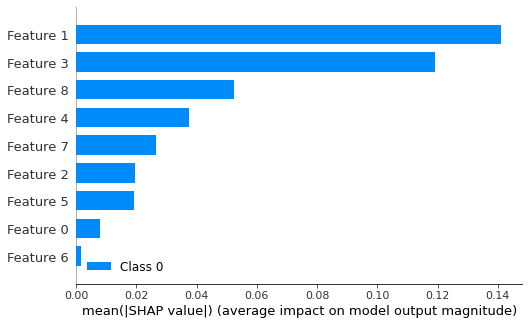

In [10]:
shap.summary_plot(shap_vals, x_train, plot_type="bar")